In [1]:
import numpy as np

from scipy.io import loadmat
from scipy import optimize

import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import NonUniformImage
from matplotlib import cm

In [2]:
pathToDataFile = 'ex5data1.mat'

In [3]:
data = loadmat(pathToDataFile)
print(type(data))
print(data.keys())
print(data['X'].shape)
print(type(data['X']))
print(data['y'].shape)


<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
(12, 1)
<class 'numpy.ndarray'>
(12, 1)


# 1 Regularised Linear Regression

## 1.1 Data Extraction and Transformation

In [21]:
def flattenBetaX(beta, X):
    flatX = beta.flatten()
    flatX = X.flatten()
    return flatX

def reshapeBetaXy(flatBeta, flatX, flaty, sampleSize):
    reshapedBeta = flatBeta.reshape(int(X.size/sampleSize), -1)
    reshapedX = flatX.reshape(sampleSize, -1)
    reshapedy = flaty.reshape(sampleSize, -1)
    return reshapedBeta, reshapedX, reshapedy

# def getData(pathToDataFile, x_heading, y_heading):
#     data = loadmat(pathToDataFile)
#     dataFrame = pd.DataFrame({'x1':data[x_heading].flatten(), 'y':data[y_heading].flatten()})
#     dataFrame.insert(0, 'x0', 1)
#     nRows, nColumns = dataFrame.shape
#     X = dataFrame[['x0','x1']]
#     y = dataFrame[['y']]
#     beta = pd.DataFrame(np.zeros(X.shape[1]), columns = ['beta'])
#     return beta, X, y

def getData(pathToDataFile, xLabel, yLabel):
    data = loadmat(pathToDataFile)
    X = np.insert(data[xLabel], 0, 1, axis=1)
    y = data[yLabel]
    sampleSize, numVariables = X.shape
    beta = np.zeros(numVariables)
    return beta, X.flatten(), y.flatten()

In [22]:
sampleSize, nVariables = data['X'].shape

beta, X, y = getData(pathToDataFile, 'X', 'y')

beta, X, y = reshapeBetaXy(beta, X, y, sampleSize)
beta

array([[ 0.],
       [ 0.]])

## 1.2 Data Visualisation

### 1.2.1 Training Set

In [ ]:
beta, X, y = getData(pathToDataFile, 'X', 'y')
sampleSize, nVariables = X.shape

In [ ]:
pd.DataFrame(reshapeX(flattenX(X), sampleSize))

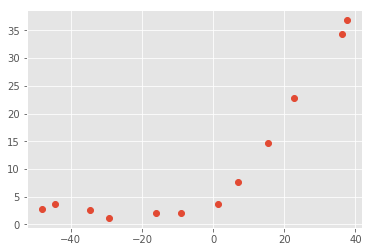

(12, 2)


In [26]:
flatBeta, flatX, flaty = getData(pathToDataFile, 'X', 'y')
beta, X, y = reshapeBetaXy(flatBeta, flatX, flaty, sampleSize)
plt.plot(X[:,-1], y, 'o')
plt.show()
print (X.shape)

### 1.2.2 Validation Set

In [ ]:
beta, X_val, y_val = getData(pathToDataFile, 'Xval', 'yval')
plt.plot(X_val['x1'], y_val, 'o')
plt.show()
print (X_val.shape)

### 1.2.3 Test Set

In [ ]:
beta, X_test, y_test = getData(pathToDataFile, 'Xtest', 'ytest')
plt.plot(X_test['x1'], y_test, 'o')
plt.show()
print (X_test.shape)

## 1.3 Regularised Linear Regression

**Hypothesis** $h_{\beta}(X) =  X\cdot\beta$

**Error** $e = (h_{\beta}(X) - y)$

**Cost Function** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2}$

**Regularisation Term** $R = \frac{\lambda}{2n}{\sum{\beta}^2}$

**Regularised Cost** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2} + \frac{\lambda}{2n}{\sum{\beta}^2}$

**Gradient** $\frac{\partial J}{\partial \beta _0} = \frac{1}{n}X^{T}\cdot e$<br\>
$\frac{\partial J}{\partial \beta _{≠0}} = \frac{1}{n}X^{T}\cdot e + \frac{\lambda}{n}\beta$<br\>

In the code $\frac{\partial J}{\partial \beta}$ is denoted symply as **g**.

In [ ]:
def hypothesis(beta, flatX):
    X = reshapeX(flatX, sampleSize)
#     return hypothesis vector h(n, 1), where n is sampleSize
    return np.dot(X, beta)

def costFunction(beta, flatX, sampleSize, y, iLambda=0.):
    X = reshapeX(flatX, sampleSize)
#     hypothesis vector h(n, 1)
    h = hypothesis(beta, X)
#     cost scalar J(1, 1); technically the result is an array (1,1) rather than a float
    J = np.dot((y-h).T, y-h)/(2*sampleSize)
#     similarly cost J can be calculated using np.sum
#     J = np.sum((y-h)**2)/(2*sampleSize)
    R = iLambda*np.dot(beta.T, beta)/(2*sampleSize)
    return (J + R)[0][0]

def gradient(beta, flatX, sampleSize, y, iLambda=0.):
    X = reshapeX(flatX, sampleSize)
#     hypothesis vector h(n, 1)
    h = hypothesis(beta, X)
#     error vector e(n, 1) = h(n, 1) - y(n, 1)
    e = h - y
#     gradient vector g(k, 1) = X(n, k).T*e(n, 1)*
    g = np.dot(X.T,e)/(sampleSize)
#     regularisation term vector (r(400x1)) — derivative of the regularisation term of the cost funtion
    r = beta[1:]*(iLambda/sampleSize)
    g[1:] = g[1:] + r
    return g

In [ ]:
flatX = flattenX(X)
beta_ones = pd.DataFrame(np.ones(X.shape[1]))
print("hypothesis =", hypothesis(beta_ones, flatX))
print("J =", costFunction(beta_ones, flatX, sampleSize, y))
print("gradient =", gradient(beta_ones, flatX, sampleSize, y, iLambda=0.))
(gradient(beta_ones, flatX, sampleSize, y, iLambda=0.)).shape

In [ ]:
def betaOptimisation(beta, X, y, iLambda=0.):
    betaArray = {}
    for i in np.unique(data['y']):
        
        optimisedBeta = optimize.minimize(costFunction, beta, args=(X, y == i, iLambda), method=None,
                                          jac=gradient, options={'maxiter':50})
        betaArray[i] = optimisedBeta['x']

#         optimisedBeta = optimize.fmin_cg(costFunction, fprime=gradient, x0=beta, args=(X, y == i, iLambda),
#                                          maxiter=50, disp=False, full_output=True)
#         betaArray[i] = optimisedBeta[0]
    return(betaArray)

In [ ]:
iLambda = 0.
optimisedBeta = optimize.minimize(costFunction, beta, args=(flatX, sampleSize, y , iLambda), method=None,
                                      jac=gradient, options={'maxiter':50})

In [ ]:
np.arange(12).reshape(-1, 3)